In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi
import xml.etree.ElementTree as et
import os
import matplotlib.pyplot as plt
import numpy as np

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
trisoPkFrac = 0.3
pebblePkFrac = 0.64


erchPercent = range(5,21)
U_form = 1;
O_form = 2;
rho_fuel = 10.96; # g/cm3

trisoPartThicknesses = [253.5, 97.7, 41.9, 37.5, 45.6]; #um

coolTemp = 450+273.15 #C -> K
coolPres = 8 #MPa

In [3]:
#      Buffer
buffer = openmc.Material(name='Buffer')
buffer.set_density('g/cm3', 1.0)
buffer.add_element('C', 1.0)
#buffer.add_s_alpha_beta('c_Graphite')

#      IPyC
IPyC = openmc.Material(name='IPyC')
IPyC.set_density('g/cm3', 1.9)
IPyC.add_element('C', 1.0)
#IPyC.add_s_alpha_beta('c_Graphite')

#      SiC
SiC = openmc.Material(name='SiC')
SiC.set_density('g/cm3', 3.2)
SiC.add_element('C', 0.5)
SiC.add_element('Si', 0.5)

#      OPyC
OPyC = openmc.Material(name='OPyC')
OPyC.set_density('g/cm3', 1.87)
OPyC.add_element('C', 1.0)
#OPyC.add_s_alpha_beta('c_Graphite')

# Moderator
graphite = openmc.Material()
graphite.set_density('g/cm3', 1.1995)
graphite.add_element('C', 1.0)
#graphite.add_s_alpha_beta('c_Graphite')

# Coolant
He = openmc.Material(name='He')
He.set_density('g/cm3',coolPres/coolTemp/2.0771)
He.add_element('He',1.0)
He.temperature = coolTemp

In [4]:
#B5
trisoPartRads = trisoPartThicknesses
for i in range(1,5):
    trisoPartRads[i] += trisoPartRads[i-1]
trisoPartVolFracs = trisoPartRads
for i in range(5):
    trisoPartVolFracs[i] = (trisoPartRads[i]/trisoPartRads[4])**3
for i in range(4):
    trisoPartVolFracs[4-i] -= trisoPartVolFracs[3-i]
    


In [5]:
#B6
pebbleRads = [25, 30]
pebbleVolFracs = pebbleRads
for i in range(2):
    pebbleVolFracs[i] = (pebbleRads[i]/pebbleRads[1])**3
pebbleVolFracs[1] -= pebbleVolFracs[0]

In [6]:
#Enrichment Optimization
k_inf_erchPercent = []
kieP = []
for epi in erchPercent:
    #B4
    # TRISO Particles
    
    #      Fuel Kernel
    fuel = openmc.Material(name="fuel")
    fuel.set_density('g/cm3', rho_fuel)
    fuel.add_nuclide('U235',epi/100*U_form/(U_form+O_form))
    fuel.add_nuclide('U238',((1-epi/100)*U_form/(U_form+O_form)))
    fuel.add_element('O', O_form/(U_form+O_form))

    
    homogTrisoPart = openmc.Material.mix_materials([fuel, buffer, IPyC, SiC, OPyC], trisoPartVolFracs, 'vo')

    homogTrisoPebCore = openmc.Material.mix_materials([homogTrisoPart,graphite], [trisoPkFrac, 1-trisoPkFrac], 'vo');
    homogTrisoPebble = openmc.Material.mix_materials([homogTrisoPebCore, graphite], pebbleVolFracs, 'vo');


    #B7
    homogCore = openmc.Material.mix_materials([homogTrisoPebble, He], [pebblePkFrac, 1-pebblePkFrac], 'vo')
    homogCore.add_s_alpha_beta('c_Graphite')
    materials = openmc.Materials()
    materials += [homogCore]
    materials.export_to_xml()
    
        #B8
    space = openmc.model.RightCircularCylinder([0,0,0], 125, 50, axis='z', boundary_type='reflective')
    rxr = openmc.Cell(fill=homogCore, region=-space)
    #universe = openmc.Universe(cells=[rxr])
    universe = openmc.Universe()
    universe.add_cells([rxr])
    geometry = openmc.Geometry()
    geometry.root_universe = universe
    geometry.export_to_xml()
    settings = openmc.Settings()
    settings.run_mode = 'eigenvalue'
    settings.particles = 25000
    
    settings.batches = 45
    settings.inactive = 15
    settings.temperature={'method':'interpolation','range':(250,2500)}
    
    box = openmc.stats.Box(lower_left=(-50,-50,0), 
                          upper_right=(50,50,125),
                          only_fissionable=True);
    src =openmc.Source(space=box);
    settings.source=src;
    
    
    settings.export_to_xml()
    

    #B9
    num_threads_des = 36  # set as desired.  Can be useful to ensure you do not take over all the resources for a machine
    num_threads = min(os.cpu_count(),num_threads_des); # prevent asking for more threads than OMP_NUM_THREADS
    
    openmc.run(threads = num_threads, output=True)
    
    # consider something like this for opening the statepoint file
    sp_fn = "statepoint.%u.h5" % settings.batches # statepoint file name
    sp = openmc.StatePoint(sp_fn) # open with filename
    
    keff = sp.keff
    k_inf_erchPercent.append(keff.n)
    kieP.append(keff.s)
    sp.close()

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                #########

 Reading O16 from /home/sblair/OMC_DATA/endfb71_hdf5/O16.h5
 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading He3 from /home/sblair/OMC_DATA/endfb71_hdf5/He3.h5
 Reading He4 from /home/sblair/OMC_DATA/endfb71_hdf5/He4.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 250 K
 Maximum neutron data temperature: 2500 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1

       26/1    0.98838    0.98314 +/- 0.00383
       27/1    0.97979    0.98286 +/- 0.00351
       28/1    0.97369    0.98216 +/- 0.00330
       29/1    0.97598    0.98172 +/- 0.00309
       30/1    0.99060    0.98231 +/- 0.00293
       31/1    1.00028    0.98343 +/- 0.00297
       32/1    0.98354    0.98344 +/- 0.00279
       33/1    0.98131    0.98332 +/- 0.00263
       34/1    0.98898    0.98362 +/- 0.00251
       35/1    0.98006    0.98344 +/- 0.00238
       36/1    0.97167    0.98288 +/- 0.00234
       37/1    0.97681    0.98260 +/- 0.00224
       38/1    0.97489    0.98227 +/- 0.00217
       39/1    0.97893    0.98213 +/- 0.00208
       40/1    0.96673    0.98151 +/- 0.00209
       41/1    0.99311    0.98196 +/- 0.00206
       42/1    0.98524    0.98208 +/- 0.00198
       43/1    0.97513    0.98183 +/- 0.00193
       44/1    0.99060    0.98213 +/- 0.00188
       45/1    0.98071    0.98209 +/- 0.00182
 Creating state point statepoint.45.h5...

 =======================>     TIMING 

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                #########

 Reading O16 from /home/sblair/OMC_DATA/endfb71_hdf5/O16.h5
 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading He3 from /home/sblair/OMC_DATA/endfb71_hdf5/He3.h5
 Reading He4 from /home/sblair/OMC_DATA/endfb71_hdf5/He4.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 250 K
 Maximum neutron data temperature: 2500 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1

       26/1    1.04664    1.04741 +/- 0.00349
       27/1    1.05164    1.04776 +/- 0.00320
       28/1    1.04931    1.04788 +/- 0.00295
       29/1    1.02695    1.04639 +/- 0.00311
       30/1    1.05959    1.04727 +/- 0.00303
       31/1    1.05102    1.04750 +/- 0.00284
       32/1    1.04886    1.04758 +/- 0.00267
       33/1    1.04196    1.04727 +/- 0.00254
       34/1    1.04386    1.04709 +/- 0.00241
       35/1    1.05770    1.04762 +/- 0.00234
       36/1    1.03594    1.04706 +/- 0.00230
       37/1    1.03678    1.04660 +/- 0.00224
       38/1    1.06221    1.04728 +/- 0.00225
       39/1    1.03035    1.04657 +/- 0.00226
       40/1    1.06134    1.04716 +/- 0.00225
       41/1    1.04095    1.04692 +/- 0.00217
       42/1    1.03809    1.04659 +/- 0.00212
       43/1    1.04260    1.04645 +/- 0.00205
       44/1    1.04065    1.04625 +/- 0.00198
       45/1    1.05088    1.04641 +/- 0.00192
 Creating state point statepoint.45.h5...

 =======================>     TIMING 

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                #########

 Reading O16 from /home/sblair/OMC_DATA/endfb71_hdf5/O16.h5
 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading He3 from /home/sblair/OMC_DATA/endfb71_hdf5/He3.h5
 Reading He4 from /home/sblair/OMC_DATA/endfb71_hdf5/He4.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 250 K
 Maximum neutron data temperature: 2500 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1

       25/1    1.11238    1.10159 +/- 0.00226
       26/1    1.09082    1.10061 +/- 0.00227
       27/1    1.08992    1.09972 +/- 0.00226
       28/1    1.08769    1.09880 +/- 0.00227
       29/1    1.09810    1.09875 +/- 0.00210
       30/1    1.09035    1.09819 +/- 0.00204
       31/1    1.09626    1.09807 +/- 0.00191
       32/1    1.09451    1.09786 +/- 0.00181
       33/1    1.09210    1.09754 +/- 0.00173
       34/1    1.09643    1.09748 +/- 0.00164
       35/1    1.08978    1.09709 +/- 0.00160
       36/1    1.10713    1.09757 +/- 0.00160
       37/1    1.10012    1.09769 +/- 0.00153
       38/1    1.09218    1.09745 +/- 0.00148
       39/1    1.09257    1.09724 +/- 0.00143
       40/1    1.09320    1.09708 +/- 0.00138
       41/1    1.10287    1.09731 +/- 0.00135
       42/1    1.10481    1.09758 +/- 0.00132
       43/1    1.10397    1.09781 +/- 0.00130
       44/1    1.10774    1.09815 +/- 0.00130
       45/1    1.08210    1.09762 +/- 0.00136
 Creating state point statepoint.4

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                #########

 Reading O16 from /home/sblair/OMC_DATA/endfb71_hdf5/O16.h5
 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading He3 from /home/sblair/OMC_DATA/endfb71_hdf5/He3.h5
 Reading He4 from /home/sblair/OMC_DATA/endfb71_hdf5/He4.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 250 K
 Maximum neutron data temperature: 2500 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1

       26/1    1.14869    1.14094 +/- 0.00382
       27/1    1.14351    1.14116 +/- 0.00350
       28/1    1.15065    1.14189 +/- 0.00330
       29/1    1.13473    1.14138 +/- 0.00310
       30/1    1.13874    1.14120 +/- 0.00289
       31/1    1.14575    1.14149 +/- 0.00272
       32/1    1.13718    1.14123 +/- 0.00256
       33/1    1.15075    1.14176 +/- 0.00247
       34/1    1.14456    1.14191 +/- 0.00235
       35/1    1.13752    1.14169 +/- 0.00224
       36/1    1.13801    1.14151 +/- 0.00213
       37/1    1.13952    1.14142 +/- 0.00204
       38/1    1.15342    1.14194 +/- 0.00201
       39/1    1.14123    1.14192 +/- 0.00193
       40/1    1.13656    1.14170 +/- 0.00186
       41/1    1.14094    1.14167 +/- 0.00179
       42/1    1.11906    1.14083 +/- 0.00192
       43/1    1.14428    1.14096 +/- 0.00185
       44/1    1.13973    1.14092 +/- 0.00179
       45/1    1.13159    1.14060 +/- 0.00175
 Creating state point statepoint.45.h5...

 =======================>     TIMING 

<ErrorbarContainer object of 3 artists>

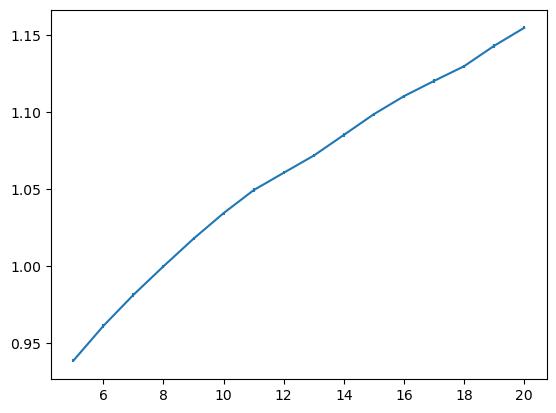

In [7]:
plt.errorbar(np.array(erchPercent), np.array(k_inf_erchPercent), np.array(kieP))

In [8]:
trisoPkFrac = range(30,60,2)
erchPercent = .1975

In [9]:
#      Fuel Kernel
fuel = openmc.Material(name="fuel")
fuel.set_density('g/cm3', rho_fuel)
fuel.add_nuclide('U235',erchPercent*U_form/(U_form+O_form))
fuel.add_nuclide('U238',((1-erchPercent)*U_form/(U_form+O_form)))
fuel.add_element('O', O_form/(U_form+O_form))
homogTrisoPart = openmc.Material.mix_materials([fuel, buffer, IPyC, SiC, OPyC], trisoPartVolFracs, 'vo')

In [10]:
#Enrichment Optimization
k_inf_tPkFrac = []
kitPF = []
for eki in trisoPkFrac:
    #B4
    homogTrisoPebCore = openmc.Material.mix_materials([homogTrisoPart,graphite], [eki/100, 1-eki/100], 'vo');
    homogTrisoPebble = openmc.Material.mix_materials([homogTrisoPebCore, graphite], pebbleVolFracs, 'vo');


    #B7
    homogCore = openmc.Material.mix_materials([homogTrisoPebble, He], [pebblePkFrac, 1-pebblePkFrac], 'vo')
    homogCore.add_s_alpha_beta('c_Graphite')
    materials = openmc.Materials()
    materials += [homogCore]
    materials.export_to_xml()
    
        #B8
    space = openmc.model.RightCircularCylinder(0, 1.25, .5, axis='z', boundaryType="vacuum")
    rxr = openmc.Cell(fill=homogCore, region=-space)
    universe = openmc.Universe(cells=[rxr])
    geometry = openmc.Geometry()
    geometry.root_universe = universe
    geometry.export_to_xml()
    settings = openmc.Settings()
    settings.run_mode = 'eigenvalue'
    settings.particles = 25000
    settings.batches = 45
    settings.inactive = 15
    settings.temperature={'method':'interpolation','range':(250,2500)}
    settings.export_to_xml()

    

    #B9
    num_threads_des = 36  # set as desired.  Can be useful to ensure you do not take over all the resources for a machine
    num_threads = min(os.cpu_count(),num_threads_des); # prevent asking for more threads than OMP_NUM_THREADS
    
    openmc.run(threads = num_threads, output=True)
    sp = openmc.StatePoint('statepoint.45.h5')
    keff = sp.keff
    k_inf_tPkFrac.append(keff.n)
    kitPF.append(keff.s)
    sp.close()

TypeError: cannot unpack non-iterable int object

In [ ]:
plt.errorbar(np.array(trisoPkFrac), np.array(k_inf_tPkFrac),np.array(kitPF))